# Pixel-level

By Cascade Tuholske, Sep 2020 <br>
Notebook to generate pixel agreement, coeffiecent of variation of popgrid data, and distributions of pixels. <br>

**Always check file order to drop gpwv4**

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio 
import xarray as xr
import geopandas as gpd
import glob
import rioxarray as rio
from scipy.stats import variation 
import rasterio.mask
import matplotlib.pyplot as plt

## Pixel Aggreement

In [2]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_M-M-Z.tif'

In [3]:
# 2021.01.20 - keeping GPWv4
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all'+country)
for rst in rst_fns: print(rst) # check them
# del rst_fns[0] # drop GPv4
rst_fns

/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_M-M-Z.tif


['/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_M-M-Z.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_M-M-Z.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_M-M-Z.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_M-M-Z.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_M-M-Z.tif']

In [ ]:
# Get all arrays
arrs = []

for rst in rst_fns:
    arr = rasterio.open(rst).read(1)
    arrs.append(arr)

In [ ]:
# find areas of agreement
zeros = []
for arr in arrs:
    zero = arr > -999
    zero = zero.astype(int)
    zeros.append(zero)

agg = sum(zeros)

In [ ]:
agg32 = agg.astype('int32')

In [ ]:
# get meta data & write raster 
out_meta = rasterio.open(rst_fns[0]).meta
out_meta['dtype'] = 'int32'

In [ ]:
fn_out = DATA_PATH+'interim/agg'+country
with rasterio.open(fn_out, "w", **out_meta) as dest:
    dest.write(agg32, 1)

## Range across rasters

In [4]:
def open_rst(rst_fn):
    "function opens a raster and makes it into a xarray object"
    
    rst = xr.DataArray(rasterio.open(rst_fn).read(1), dims = ['y', 'x']) # y and x are our 2-d labels
    
    return rst

In [73]:
def rst_range(rst_fns, fn_out, save = False):
    """ Calc pixel-level range on stacked arrays and writes it out as a raster, returns the range, max and min arrs
    fst_fns = list of rasters 
    fn_out = file name and path to write out coef var raster
    save = if save == true, will write raster, default = False
    
    """
    
    arr_list = [] # empty list
    
    # open and stack arrays
    for rst_fn in rst_fns:
        
      
        rst_arr = rasterio.open(rst_fn).read(1)
        arr_list.append(rst_arr)
    
    arr3d = np.dstack([arr_list])
        
    # mask zeros
    arr3d[arr3d == -999] = 0 # Set NAN to zeros
        
    # Get range
    arr_min = np.amin(arr3d, axis = 0)
    arr_max = np.amax(arr3d, axis = 0)
    arr_range = arr_max - arr_min
    arr_out = arr_range.data
    
    # get meta data & write raster 
    out_meta = rasterio.open(rst_fns[0]).meta
    out_meta.update({'dtype' : 'float64'})
    
    if save == True: 
        with rasterio.open(fn_out, "w", **out_meta) as dest:
            dest.write(arr_out, 1)
        
    return arr_range, arr_max, arr_min

In [174]:
#### File Paths & FNs --- Update by geography
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = 'rural_M-M-Z.tif'
title = 'MMZ Rural'
color = 'deeppink' # deeppink rural, darkslateblue urban 
# fn_out = DATA_PATH+'interim/all_range'+country for tif
fn_out = DATA_PATH+'FIGS/Fig1_rural_MMZ.png'

In [175]:
# range all tif files
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*'+country)
for rst in rst_fns: print(rst) # check them


/Users/cascade/Github/PopGridCompare/data/interim/WP16_rural_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_rural_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/GHS15_rural_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_rural_M-M-Z.tif
/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_rural_M-M-Z.tif


In [176]:
# Range Rst
range_all, max_all, min_all = rst_range(rst_fns, fn_out, save = False)


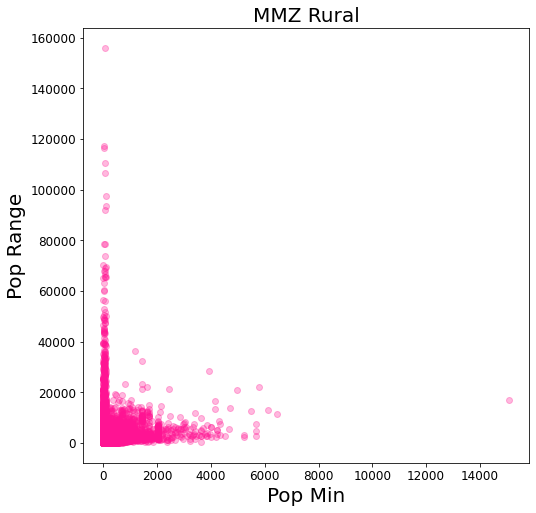

In [177]:
# Scatter
fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

# plot
X = np.delete(min_all.flatten(), np.where(range_all.flatten() == 0)) # remove all zero ranges
Y = np.delete(range_all.flatten(), np.where(range_all.flatten() == 0)) # remove all zero ranges
axs.scatter(X, Y, alpha = 0.3, color = color, marker = 'o')#, edgecolors = 'darkslategray')


# titles & lables & ticks
axs.set_title(title, fontsize = 20)
axs.set_xlabel('Pop Min', fontsize = 20)
axs.set_ylabel('Pop Range', fontsize = 20)
axs.tick_params(axis = 'both', which = 'major', labelsize = 12)
axs.tick_params(axis = 'both', which = 'minor', labelsize = 12)

#fn_out = DATA_PATH+'FIGS/MS/Fig1_'+title+'.png'
plt.savefig(fn_out, dpi = 300, bbox_inches='tight', facecolor = 'w')

## What are the stats?

In [178]:
# File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [179]:
def get_stats(country, mask):
    
    """ gets count of rural/urban pixels, max and inhabitied pixels 
    Args: 
        country = country.tif
        mask = full path file name of bianary raster for the country's area 
    """
    
    # Stuff to fill
    df = pd.DataFrame()
    
    countries = []
    labels = []
    urban_counts = []
    urban_maxs = []
    urban_sums = []
    rural_counts = []
    rural_maxs = []
    rural_sums = []
    uninhabated = []
    pcts = []
    
    # urban labels, counts & max
    rst_fns = sorted(glob.glob(DATA_PATH+'interim/*urban_'+country))
    for rst in rst_fns:
        
        label = rst.split('interim/')[1].split('_urban')[0]
        labels.append(label)
        cmax = rasterio.open(rst).read(1).flatten().max()
        urban_maxs.append(cmax)
        urban = list(filter(lambda x: x > 0, rasterio.open(rst).read(1).flatten()))
        urban_count = len(urban)
        urban_sum = sum(urban)
        urban_counts.append(urban_count)
        urban_sums.append(urban_sum)
    
    # rural labels, counts & max
    rst_fns = sorted(glob.glob(DATA_PATH+'interim/*rural_'+country))
    for rst in rst_fns:
        
        cmax = rasterio.open(rst).read(1).flatten().max()
        rural_maxs.append(cmax)
        rural = list(filter(lambda x: x > 0, rasterio.open(rst).read(1).flatten()))
        rural_count = len(rural)
        rural_sum = sum(rural)
        rural_counts.append(rural_count)
        rural_sums.append(rural_sum)
    
    # Uninhabitated 
    rst_fns = sorted(glob.glob(DATA_PATH+'interim/*all_'+country))
    for rst in rst_fns:
        a = len(list(filter(lambda x: x != -999, rasterio.open(rst).read(1).flatten()))) # ! nan pixels
        b = len(list(filter(lambda x: x == 1, rasterio.open(mask).read(1).flatten()))) # all pixels w/in bounds
        c = b - a
        pct = c / b * 100 # pct uninhabated
        uninhabated.append(c)
        pcts.append(pct)

        
    # Population dataframe
    df['country'] = [country.split('.tif')[0]] * len(rst_fns)
    df['label'] = labels
    df['urban_max'] = urban_maxs
    df['rural_max'] = rural_maxs
    df['urban_sum'] = urban_sums
    df['rural_sum'] = rural_sums
    df['total_pop'] = df['urban_sum'] + df['rural_sum']
    df['urban_count'] = urban_counts
    df['rural_count'] = rural_counts
    df['uninhabated'] = uninhabated
    df['pct'] = pcts
    
    return df

In [180]:
# Get stats Nepal
country = 'Nepal.tif'
mask_fn = DATA_PATH+'interim/Nepal-rst.tif'
df1 = get_stats(country, mask_fn)

In [181]:
# Get stats Ecu
country = 'Ecuador.tif'
mask_fn = DATA_PATH+'interim/ECU-rst.tif'
df2 = get_stats(country, mask_fn)

In [182]:
# Get stats MMZ
country = 'M-M-Z.tif'
mask_fn = DATA_PATH+'interim/M-M-Z-rst.tif'
df3 = get_stats(country, mask_fn)

In [183]:
# Concat
dfs = [df1, df2, df3]
df_out = pd.concat(dfs)
df_out

,country,label,urban_max,rural_max,urban_sum,rural_sum,total_pop,urban_count,rural_count,uninhabated,pct
0,Nepal,ESRI16,45982.000000,25237.000000,2.660928e+06,3.071215e+07,3.337308e+07,275,118437,76844,39.295138
1,Nepal,GHS15,46471.505188,117461.807631,3.297929e+06,2.515812e+07,2.845605e+07,271,104208,91077,46.573360
2,Nepal,GPWv4,32592.427734,28114.048828,2.879139e+06,2.783803e+07,3.071717e+07,275,175048,20233,10.346397
3,Nepal,LS15,57668.000000,44892.000000,2.848601e+06,2.869185e+07,3.154045e+07,275,145639,49642,25.385056
4,Nepal,WP16,48357.726562,46939.121094,3.638684e+06,2.859899e+07,3.223767e+07,275,167188,28093,14.365706
0,Ecuador,ESRI16,18108.000000,14867.000000,7.971993e+06,1.028335e+07,1.825534e+07,1457,41897,247071,85.072222
1,Ecuador,GHS15,31851.356346,43016.577565,8.186492e+06,7.859950e+06,1.604644e+07,1510,41755,247160,85.102866
2,Ecuador,GPWv4,4172.059082,4172.061035,2.060541e+06,1.383180e+07,1.589234e+07,1664,235809,52952,18.232590
3,Ecuador,LS15,44304.000000,31740.000000,7.577307e+06,8.239101e+06,1.581641e+07,1645,192868,95912,33.024705
4,Ecuador,WP16,8782.316406,8427.628906,5.354677e+06,1.087071e+07,1.622539e+07,1663,224407,64355,22.158905


In [ ]:
# Write it out
fn_out = DATA_PATH+'processed/Table1.csv'
df_out.to_csv(fn_out)

## Coef Var

In [ ]:
def open_rst(rst_fn):
    "function opens a raster and makes it into a xarray object"
    
    rst = xr.DataArray(rasterio.open(rst_fn).read(1), dims = ['y', 'x']) # y and x are our 2-d labels
    
    return rst

In [ ]:
def rst_coefvar(rst_fns, fn_out):
    """ Calc coef of var on stacked arrays and writes it out as a raster, returns the arr
    fst_fns = list of rasters 
    fn_out = file name and path to write out coef var raster
    """
    
    arr_list = [] # empty list
    
    # open and stack arrays
    for rst_fn in rst_fns:
        
      
        rst_arr = rasterio.open(rst_fn).read(1)
        arr_list.append(rst_arr)
    
    arr3d = np.dstack([arr_list])
        
    # mask zeros
    arr3d[arr3d == -999] = 'nan'
        
    # calculate variance across rasters & get data
    var = variation(arr3d, axis=0, nan_policy = 'propagate')
    arr_out = var.data
    
    # get meta data & write raster 
    out_meta = rasterio.open(rst_fns[0]).meta
    out_meta.update({'dtype' : 'float64'})
    
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(arr_out, 1)
        
    return var

In [ ]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_Ecuador.tif'
title = 'Ecuador'

In [ ]:
# coefvar all tif files
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all'+country)
for rst in rst_fns: print(rst) # check them
print('\n DID YOU DROP GPWv4???? <<<<----------------------------')

In [ ]:
del rst_fns[0] # drop GPv4
print('\n')
for rst in rst_fns: print(rst) # check them
print('\n DID YOU DROP GPWv4???? <<<<----------------------------')

In [ ]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_Ecuador.tif'

In [ ]:
# Variance Rst
fn_out = DATA_PATH+'interim/all_coefvar'+country
varall = rst_coefvar(rst_fns, fn_out)
fn_out = DATA_PATH+'FIGS/MS/Fig1_'+title+'.png'

In [ ]:
# Plot
fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
#fig.subplots_adjust(wspace=ws)
axs.hist(varall.flatten(), density = False, bins = 50, ec = 'midnightblue', color = 'dodgerblue', alpha = 0.7);
axs.set_title(title, fontsize = 20)
axs.set_xlabel('coefficient of variation', fontsize = 15)
axs.set_ylabel('count', fontsize = 15)

plt.savefig(fn_out, dpi = 300, bbox_inches='tight', facecolor = 'w')

## Distribution of Pixels

In [ ]:
fn_out = DATA_PATH+'FIGS/MS/Fig2.png'

In [ ]:
def flat(rst_fn):
    "helper to flatten 2d array for histogramss"
    arr = rasterio.open(rst_fn).read(1)
    flat = arr.flatten()
    
    # revalue na -999
    flat = np.where(flat==-999, 0, flat) 
    
    return flat

In [ ]:
def get_rsts(country_list):
    "get the rasters to plot by country, drops GPWv4"
    
    rsts_out = [] # out list
    
    for country in country_list:
        
        rst_fns = sorted(glob.glob(DATA_PATH+'interim/*all'+country)) # get rst nms
        
        for i, rst in enumerate(rst_fns): # drop gwpv4
            
            nm = rst.split('interim/')[1].split('_all')[0]      
            if nm == 'GPWv4':
                del rst_fns[i]
        
        rsts_out.append(rst_fns) # append list
        
    return rsts_out

In [ ]:
countries = ['_Nepal.tif','_M-M-Z.tif','_Ecuador.tif',]

In [ ]:
all_rsts = get_rsts(countries)

In [ ]:
# Always update 'GPWv4-15'
names = ['WPE-16', 'GHS-15', 'LS-15', 'WP-16',]

In [ ]:
#### Make Figure & Save it

#rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(4, 3, figsize = (16, 16), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

xticks = [25000,75000,125000]

# Nepal
for i, rst_fn in enumerate(zip(all_rsts[0], names)):
    data = flat(rst_fn[0])
    axs[i][0].hist(data, log = True, color = 'deeppink', alpha = 0.7, lw = 1, ec = 'firebrick');#, bins = 10);
    axs[i][0].set_title(rst_fn[1], fontsize = 15)
    axs[i][0].set_xticks(xticks)
    axs[i][0].tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs[i][0].tick_params(axis = 'both', which = 'minor', labelsize = 12)
axs[0][0].legend(['Nepal']);

# MMZ
for i, rst_fn in enumerate(zip(all_rsts[1], names)):
    data = flat(rst_fn[0])
    axs[i][1].hist(data, log = True, color = 'palegreen', alpha = 0.7, lw = 1, ec = 'seagreen');#, bins = 10);
    axs[i][1].set_title(rst_fn[1], fontsize = 15)
    axs[i][1].set_xticks(xticks)
    axs[i][1].tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs[i][1].tick_params(axis = 'both', which = 'minor', labelsize = 12)
axs[0][1].legend(['MMZ']);

# Ecuador
for i, rst_fn in enumerate(zip(all_rsts[2], names)):
    data = flat(rst_fn[0])
    axs[i][2].hist(data, log = True, color = 'cornflowerblue', alpha = 0.7, lw = 1, ec = 'darkslategray', bins = 10);
    axs[i][2].set_title(rst_fn[1], fontsize = 15)
    axs[i][2].set_xticks(xticks)
    axs[i][2].tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs[i][2].tick_params(axis = 'both', which = 'minor', labelsize = 12)
axs[0][2].legend(['Ecuador']);

# Save it
plt.savefig(fn_out, dpi = 300, bbox_inches='tight', facecolor = 'w')

In [ ]:
#### Make Figure & Save it
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_Nepal.tif')
rst_fns

#rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)


data = flat(rst_fns[0])
axs.hist(data, log = True, color = 'green', lw = 5, alpha = 0.5, ec = 'green', histtype=u'step');
data = flat(rst_fns[1])
axs.hist(data, log = True, color = 'red', lw = 5, alpha = 0.5, ec = 'red', histtype=u'step');
data = flat(rst_fns[2])
axs.hist(data, log = True, color = 'blue', lw = 5, alpha = 0.5, ec = 'blue', histtype=u'step');
data = flat(rst_fns[3])
axs.hist(data, log = True, color = 'orange', lw = 5, alpha = 0.5, ec = 'orange', histtype=u'step');